In [6]:
import os
import numpy as np
import tensorflow as tf
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm

import models

PATH = '../data/landmarks/'

IMAGE_SIZE = (128,128,3)

# Limite size of input for testing
TEST_LIMIT = 1000

SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 20
STEPS_PER_EPOCH = 40

In [2]:
# Retrieve the raw images
resized_path = PATH + 'resized/'
filenames = os.listdir(resized_path)

## Sort the filenames in the proper order
filename_int = np.sort([int(s[:-4]) for s in filenames])

filenames = np.array([resized_path + str(i) + '.jpg' for i in filename_int])

# Retrieve the masks
masks_path = PATH + 'resized_masks/'
f_masks = os.listdir(masks_path)

## Sort the filenames in the proper order
f_masks_int = np.sort([int(s[:-4]) for s in f_masks])

f_masks = np.array([resized_path + str(i) + '.jpg' for i in f_masks_int])

# Retrieve the landmarks
labels = np.load(PATH + 'resized_labels.npy')

# Reshape the outputs
print(labels.shape)
print(f_masks.shape)
print(filenames.shape)
assert len(f_masks)==len(labels)
assert len(filenames)==len(labels)

if TEST_LIMIT>len(labels):
    TEST_LIMIT = len(labels)


w,h,c = IMAGE_SIZE
images = np.empty((0,w,h,c))

masks = np.empty((0,w//4,h//4,1))

print("Loading images...")
labels = labels[:TEST_LIMIT]
labels = np.reshape(labels,(TEST_LIMIT,14))
labels = labels[:,:10]

for i in tqdm(range(TEST_LIMIT)):
    image = sk.io.imread(filenames[i])
    image_resized = sk.transform.resize(image, IMAGE_SIZE)
    images = np.vstack((images,np.expand_dims(image_resized,0)))

    mask = sk.io.imread(f_masks[i])

    mask_resized = sk.transform.resize(mask, (w//4,h//4,1))
    masks = np.vstack((masks,np.expand_dims(mask_resized,0)))



train_split = int(SPLIT*len(labels))

images_train = images[:train_split]
images_valid = images[train_split:]

masks_train = masks[:train_split]
masks_valid = masks[train_split:]

labels_train = labels[:train_split]
labels_valid = labels[train_split:]

(658, 7, 2)
(658,)
(658,)
Loading images...


  0%|                                                                                          | 0/658 [00:00<?, ?it/s]c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 658/658 [01:24<00:00,  7.78it/s]


In [3]:
layers = [10, 16, 32, 64]
model = models.MultiTaskResNet(layers, 14, IMAGE_SIZE)

print(model.summary())

losses = {
    "mask_output": "binary_crossentropy",
    "landmarks_output": "mse"
}

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=losses,
              metrics=['accuracy']) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 10) 280         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 10) 910         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [5]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '../weights/landmarks/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,
        save_weights_only=True
        ),
    tf.keras.callbacks.TensorBoard(log_dir='../output/logs')
    ]

model.fit(
    images_train,
    {"mask_output": masks_train, "landmarks_output": labels_train},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(images_valid, {"mask_output": masks_valid, "landmarks_output": labels_valid})
)

Train on 526 samples, validate on 132 samples
Epoch 1/20
526/526 [==============================] - ETA: 1:29 - loss: 54260.7148 - mask_output_loss: 29.4986 - landmarks_output_loss: 54231.2148 - mask_output_acc: 0.0078 - landmarks_output_acc: 0.18 - ETA: 42s - loss: 56966.7695 - mask_output_loss: 26.0210 - landmarks_output_loss: 56940.7480 - mask_output_acc: 0.0042 - landmarks_output_acc: 0.1562 - ETA: 27s - loss: 57091.4049 - mask_output_loss: 24.5258 - landmarks_output_loss: 57066.8789 - mask_output_acc: 0.0045 - landmarks_output_acc: 0.125 - ETA: 19s - loss: 55128.1289 - mask_output_loss: 23.7596 - landmarks_output_loss: 55104.3691 - mask_output_acc: 0.0051 - landmarks_output_acc: 0.109 - ETA: 14s - loss: 55673.7977 - mask_output_loss: 23.2820 - landmarks_output_loss: 55650.5156 - mask_output_acc: 0.0060 - landmarks_output_acc: 0.093 - ETA: 11s - loss: 56235.6035 - mask_output_loss: 22.9252 - landmarks_output_loss: 56212.6784 - mask_output_acc: 0.0060 - landmarks_output_acc: 0.078 -

Epoch 4/20
526/526 [==============================] - ETA: 2s - loss: 58781.0312 - mask_output_loss: 18.4754 - landmarks_output_loss: 58762.5547 - mask_output_acc: 0.0020 - landmarks_output_acc: 0.15 - ETA: 2s - loss: 59155.7598 - mask_output_loss: 17.8064 - landmarks_output_loss: 59137.9531 - mask_output_acc: 0.0172 - landmarks_output_acc: 0.23 - ETA: 1s - loss: 59057.3320 - mask_output_loss: 18.0331 - landmarks_output_loss: 59039.2982 - mask_output_acc: 0.0144 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 57477.6758 - mask_output_loss: 18.1753 - landmarks_output_loss: 57459.5000 - mask_output_acc: 0.0119 - landmarks_output_acc: 0.26 - ETA: 1s - loss: 56244.6320 - mask_output_loss: 18.1541 - landmarks_output_loss: 56226.4773 - mask_output_acc: 0.0132 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 55088.1836 - mask_output_loss: 18.3035 - landmarks_output_loss: 55069.8796 - mask_output_acc: 0.0139 - landmarks_output_acc: 0.24 - ETA: 1s - loss: 56088.1289 - mask_output_loss: 18.2624 - l

Epoch 7/20
526/526 [==============================] - ETA: 2s - loss: 57475.9297 - mask_output_loss: 17.5856 - landmarks_output_loss: 57458.3438 - mask_output_acc: 0.0047 - landmarks_output_acc: 0.28 - ETA: 2s - loss: 56579.4180 - mask_output_loss: 17.6919 - landmarks_output_loss: 56561.7266 - mask_output_acc: 0.0052 - landmarks_output_acc: 0.28 - ETA: 2s - loss: 54166.2917 - mask_output_loss: 17.6913 - landmarks_output_loss: 54148.6003 - mask_output_acc: 0.0039 - landmarks_output_acc: 0.22 - ETA: 1s - loss: 54944.3525 - mask_output_loss: 17.8773 - landmarks_output_loss: 54926.4756 - mask_output_acc: 0.0033 - landmarks_output_acc: 0.21 - ETA: 1s - loss: 54999.9898 - mask_output_loss: 17.8796 - landmarks_output_loss: 54982.1102 - mask_output_acc: 0.0069 - landmarks_output_acc: 0.21 - ETA: 1s - loss: 54891.1185 - mask_output_loss: 17.9306 - landmarks_output_loss: 54873.1882 - mask_output_acc: 0.0078 - landmarks_output_acc: 0.21 - ETA: 1s - loss: 55269.1691 - mask_output_loss: 18.0061 - l

Epoch 10/20
526/526 [==============================] - ETA: 2s - loss: 56179.9102 - mask_output_loss: 16.9946 - landmarks_output_loss: 56162.9141 - mask_output_acc: 0.0072 - landmarks_output_acc: 0.21 - ETA: 2s - loss: 50632.7695 - mask_output_loss: 17.5392 - landmarks_output_loss: 50615.2305 - mask_output_acc: 0.0119 - landmarks_output_acc: 0.17 - ETA: 1s - loss: 50947.1302 - mask_output_loss: 17.3532 - landmarks_output_loss: 50929.7773 - mask_output_acc: 0.0154 - landmarks_output_acc: 0.21 - ETA: 1s - loss: 50541.3242 - mask_output_loss: 17.5260 - landmarks_output_loss: 50523.7988 - mask_output_acc: 0.0126 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 51342.3523 - mask_output_loss: 17.5886 - landmarks_output_loss: 51324.7641 - mask_output_acc: 0.0120 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 51909.2435 - mask_output_loss: 17.6812 - landmarks_output_loss: 51891.5625 - mask_output_acc: 0.0103 - landmarks_output_acc: 0.24 - ETA: 1s - loss: 52412.6735 - mask_output_loss: 17.6710 - 

Epoch 13/20
526/526 [==============================] - ETA: 2s - loss: 54882.6953 - mask_output_loss: 17.6082 - landmarks_output_loss: 54865.0859 - mask_output_acc: 0.0095 - landmarks_output_acc: 0.28 - ETA: 2s - loss: 48450.9785 - mask_output_loss: 17.9809 - landmarks_output_loss: 48432.9961 - mask_output_acc: 0.0081 - landmarks_output_acc: 0.26 - ETA: 1s - loss: 50519.8203 - mask_output_loss: 17.9990 - landmarks_output_loss: 50501.8203 - mask_output_acc: 0.0081 - landmarks_output_acc: 0.27 - ETA: 1s - loss: 50151.5928 - mask_output_loss: 17.6606 - landmarks_output_loss: 50133.9316 - mask_output_acc: 0.0126 - landmarks_output_acc: 0.27 - ETA: 1s - loss: 49720.6813 - mask_output_loss: 17.8632 - landmarks_output_loss: 49702.8180 - mask_output_acc: 0.0117 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 50352.3268 - mask_output_loss: 17.8833 - landmarks_output_loss: 50334.4434 - mask_output_acc: 0.0125 - landmarks_output_acc: 0.26 - ETA: 1s - loss: 50033.6166 - mask_output_loss: 17.8681 - 

Epoch 16/20
526/526 [==============================] - ETA: 2s - loss: 44493.2617 - mask_output_loss: 18.6655 - landmarks_output_loss: 44474.5977 - mask_output_acc: 0.0042 - landmarks_output_acc: 0.31 - ETA: 2s - loss: 42386.7656 - mask_output_loss: 18.4625 - landmarks_output_loss: 42368.3047 - mask_output_acc: 0.0030 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 44016.1367 - mask_output_loss: 18.3155 - landmarks_output_loss: 43997.8229 - mask_output_acc: 0.0049 - landmarks_output_acc: 0.27 - ETA: 1s - loss: 44767.8389 - mask_output_loss: 18.1902 - landmarks_output_loss: 44749.6504 - mask_output_acc: 0.0045 - landmarks_output_acc: 0.26 - ETA: 1s - loss: 44885.5844 - mask_output_loss: 18.1309 - landmarks_output_loss: 44867.4547 - mask_output_acc: 0.0063 - landmarks_output_acc: 0.28 - ETA: 1s - loss: 45022.9316 - mask_output_loss: 18.0303 - landmarks_output_loss: 45004.9023 - mask_output_acc: 0.0061 - landmarks_output_acc: 0.29 - ETA: 1s - loss: 45288.7333 - mask_output_loss: 18.0495 - 

Epoch 19/20
526/526 [==============================] - ETA: 2s - loss: 44270.5000 - mask_output_loss: 17.9829 - landmarks_output_loss: 44252.5156 - mask_output_acc: 0.0065 - landmarks_output_acc: 0.18 - ETA: 2s - loss: 43141.9199 - mask_output_loss: 18.0120 - landmarks_output_loss: 43123.9062 - mask_output_acc: 0.0065 - landmarks_output_acc: 0.21 - ETA: 1s - loss: 41542.1185 - mask_output_loss: 18.0839 - landmarks_output_loss: 41524.0339 - mask_output_acc: 0.0121 - landmarks_output_acc: 0.23 - ETA: 1s - loss: 42171.8633 - mask_output_loss: 17.9025 - landmarks_output_loss: 42153.9600 - mask_output_acc: 0.0111 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 40929.1445 - mask_output_loss: 18.0634 - landmarks_output_loss: 40911.0805 - mask_output_acc: 0.0105 - landmarks_output_acc: 0.24 - ETA: 1s - loss: 40669.9727 - mask_output_loss: 18.0672 - landmarks_output_loss: 40651.9049 - mask_output_acc: 0.0104 - landmarks_output_acc: 0.25 - ETA: 1s - loss: 40349.8209 - mask_output_loss: 18.0102 - 

c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(32, 32, 1)


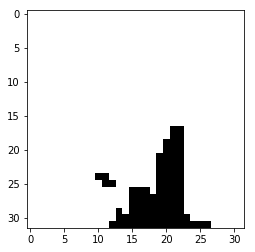

In [12]:
filenames = os.listdir(PATH+'resized/')

test_images = np.array([sk.io.imread(PATH+'resized/' + filenames[i]) for i in range(2)])

test_images = np.array([sk.transform.resize(image, IMAGE_SIZE) for image in test_images])

masks_o, landmarks = model.predict(test_images)
masks = (masks_o > 0.8).astype(np.uint8)

print(masks[0].shape)
for i in range(2):
    mask = np.squeeze(masks[i]).astype(np.float32)
    plt.imshow(np.dstack((mask,mask,mask)))
    
plt.show()